In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overriding 

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '05_27_24_SW_Pairwise'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

Error loading submitit directory: /storage/vbutoi/scratch/ESE/inference/05_27_24_SW_Pairwise/SpineWeb_Ensemble_Uncalibrated/submitit
Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 360 -> 360 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                   log_set                                              
/storage/vbutoi/scratch/ESE/inference/05_27_24_SW_Pairwise/SpineWeb_Ensemble_Uncalibrated  20240527_164906-3NI6-ac2e43e69b5150547c6925016bdca680    390
dtype: int64


In [4]:
# import pickle

# # Load all of the preds so we can compare them
# loaded_pred_dict = {}
# for pred_hash_id in inference_df['pred_hash'].unique():
#     # Get the rows corresponding to the hash
#     pred_rows = inference_df[inference_df['pred_hash'] == pred_hash_id]
#     # Get the log set corresponding to the hash
#     log_root = pred_rows['root'].unique()[0]
#     log_set = pred_rows['log_set'].unique()[0]
#     # Load the prediction pickle
#     with open(f'{log_root}/{log_set}/preds/{pred_hash_id}.pkl', 'rb') as f:
#         loaded_pred_dict[pred_hash_id] = pickle.load(f)

In [5]:
import numpy as np
import itertools
unique_subj_ids = inference_df['data_id'].unique()

pw_error_list = []
# Iterate through all the pair-wise comparisons.
for (subj_id_1, subj_id_2) in list(itertools.combinations(unique_subj_ids, 2)):
    if subj_id_1 != subj_id_2:
        # Get the dfs corresponding to these two ids:
        data_id_1_df = inference_df[inference_df['data_id'] == subj_id_1]
        data_id_2_df = inference_df[inference_df['data_id'] == subj_id_2]
        # Get the unique support indices.
        unique_sup_ids_1 = data_id_1_df['sup_idx'].unique()
        unique_sup_ids_2 = data_id_2_df['sup_idx'].unique()
        for (sup_id_1, sup_id_2) in list(itertools.product(unique_sup_ids_1, unique_sup_ids_2)):
            # Get the dfs corresponding to these sup ids
            sup_id_1_df = data_id_1_df[data_id_1_df['sup_idx'] == sup_id_1].reset_index(drop=True)
            sup_id_2_df = data_id_2_df[data_id_2_df['sup_idx'] == sup_id_2].reset_index(drop=True)

            # Get our desired quantities.
            # GT
            gt_volume_1 = sup_id_1_df['gt_volume'].values[0]
            gt_volume_2 = sup_id_2_df['gt_volume'].values[0]
            # Soft
            soft_volume_1 = sup_id_1_df['soft_volume'].values[0]
            soft_volume_2 = sup_id_2_df['soft_volume'].values[0]
            # Hard
            hard_volume_1 = sup_id_1_df['hard_volume'].values[0]
            hard_volume_2 = sup_id_2_df['hard_volume'].values[0]

            # Now we can get differences in volume by looking at the differences.
            # GT
            gt_volume_diff = gt_volume_2 - gt_volume_1
            gt_volume_quot = gt_volume_2 / gt_volume_1
            # Soft
            soft_volume_diff = soft_volume_2 - soft_volume_1
            soft_volume_quot = soft_volume_2 / soft_volume_1
            # Hard
            hard_volume_diff = hard_volume_2 - hard_volume_1
            hard_volume_quot = hard_volume_2 / hard_volume_1

            # Get the metric information from each of the dataframes
            # Dice
            dice_1 = sup_id_1_df[sup_id_1_df['image_metric'] == 'Dice']['metric_score'].iloc[0]
            dice_2 = sup_id_2_df[sup_id_2_df['image_metric'] == 'Dice']['metric_score'].iloc[0]
            # ECE
            ece_1 = sup_id_1_df[sup_id_1_df['image_metric'] == 'Image_ECE']['metric_score'].iloc[0]
            ece_2 = sup_id_2_df[sup_id_2_df['image_metric'] == 'Image_ECE']['metric_score'].iloc[0]

            # Place all of these into a record
            pair_record = {
                'subj_id_1': subj_id_1,
                'subj_id_2': subj_id_2,
                'subj_combo': f'{subj_id_1},{subj_id_2}',
                'sup_id_1': sup_id_1,
                'sup_id_2': sup_id_2,
                'dice_1': dice_1,
                'dice_2': dice_2,
                'ece_1': ece_1,
                'ece_2': ece_2,
                'mean_dice': np.mean([dice_1, dice_2]),
                'mean_ece': np.mean([ece_1, ece_2]),
                'gt_volume_diff': gt_volume_diff,
                'gt_volume_quot': gt_volume_quot,
                'soft_volume_diff': soft_volume_diff,
                'soft_volume_quot': soft_volume_quot,
                'soft_diff_error': soft_volume_diff - gt_volume_diff,
                'soft_quot_error': soft_volume_quot - gt_volume_quot,
                'hard_volume_diff': hard_volume_diff,
                'hard_volume_quot': hard_volume_quot,
                'hard_diff_error': hard_volume_diff - gt_volume_diff,
                'hard_quot_error': hard_volume_quot - gt_volume_quot,
            }
            # Add the record to the list
            pw_error_list.append(pair_record)
# Convert the final dataframe into a pandas dataframe
pairwise_df = pd.DataFrame(pw_error_list)

# Test 1: Per-subject, how do the real difference compare with respect to predicted difference?

In [6]:
# Melt the dataframe
pw_diff_df = pd.melt(
    pairwise_df, 
    id_vars=[
        'subj_id_1', 
        'subj_id_2', 
        'sup_id_1', 
        'sup_id_2', 
        'subj_combo'
    ], 
    value_vars=[
        'gt_volume_diff', 
        'soft_volume_diff', 
        'hard_volume_diff'
    ], 
    var_name='Pred_Type', 
    value_name='Volume Difference'
)


In [7]:
pw_diff_df['Pred_Type'] = pw_diff_df['Pred_Type'].astype('category')
pw_diff_df['Pred_Type'] = pw_diff_df['Pred_Type'].cat.reorder_categories([
    'soft_volume_diff',
    'hard_volume_diff',
    'gt_volume_diff',
])

Text(0.5, 1.0, 'Volume Differences Between Predictions')

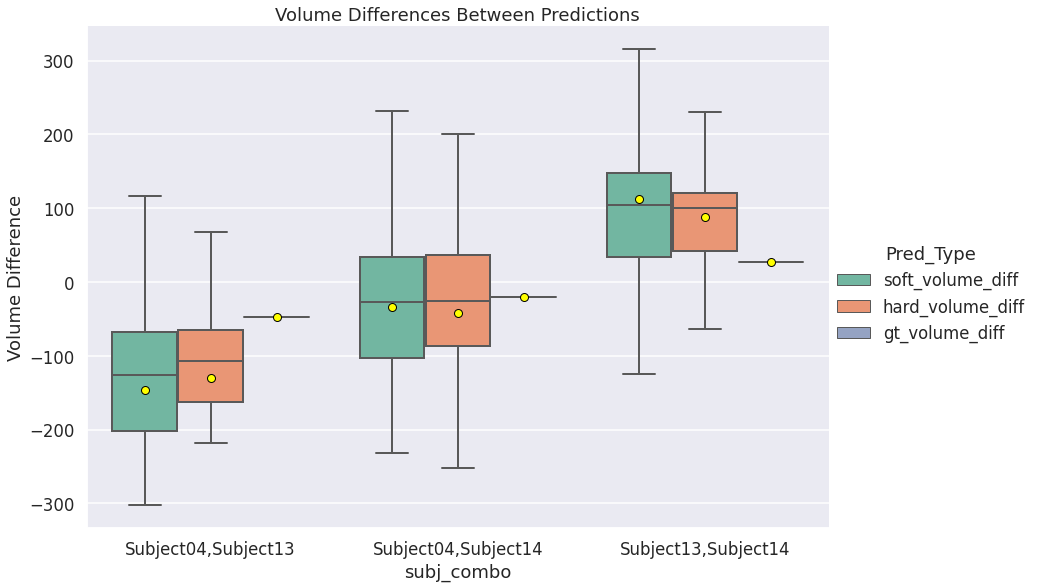

In [8]:
# Create the boxplot
g = sns.catplot(
    x='subj_combo',
    y='Volume Difference',
    kind='box',
    data=pw_diff_df,
    hue='Pred_Type',
    palette="Set2",       # Use a color palette
    linewidth=2,          # Set the linewidth of the edge
    showfliers=False,     # Do not show outliers
    aspect=1.5,            # Adjust the aspect ratio
    height=8,
    showmeans=True,       # Show the mean
    meanprops={"marker":"o", "markerfacecolor":"yellow", "markeredgecolor":"black", "markersize":"8"}
)
plt.title('Volume Differences Between Predictions')

# Test 2: Per-subject, how does the real volume quotient compare with the predicted quotient?

In [9]:
# Melt the dataframe
pw_quot_df = pd.melt(
    pairwise_df, 
    id_vars=[
        'subj_id_1', 
        'subj_id_2', 
        'sup_id_1', 
        'sup_id_2', 
        'subj_combo'
    ], 
    value_vars=[
        'gt_volume_quot', 
        'soft_volume_quot', 
        'hard_volume_quot'
    ], 
    var_name='Pred_Type', 
    value_name='Volume Quotient'
)


In [10]:
pw_quot_df['Pred_Type'] = pw_quot_df['Pred_Type'].astype('category')
pw_quot_df['Pred_Type'] = pw_quot_df['Pred_Type'].cat.reorder_categories([
    'soft_volume_quot',
    'hard_volume_quot',
    'gt_volume_quot',
])

Text(0.5, 1.0, 'Volume Quotient Comparison')

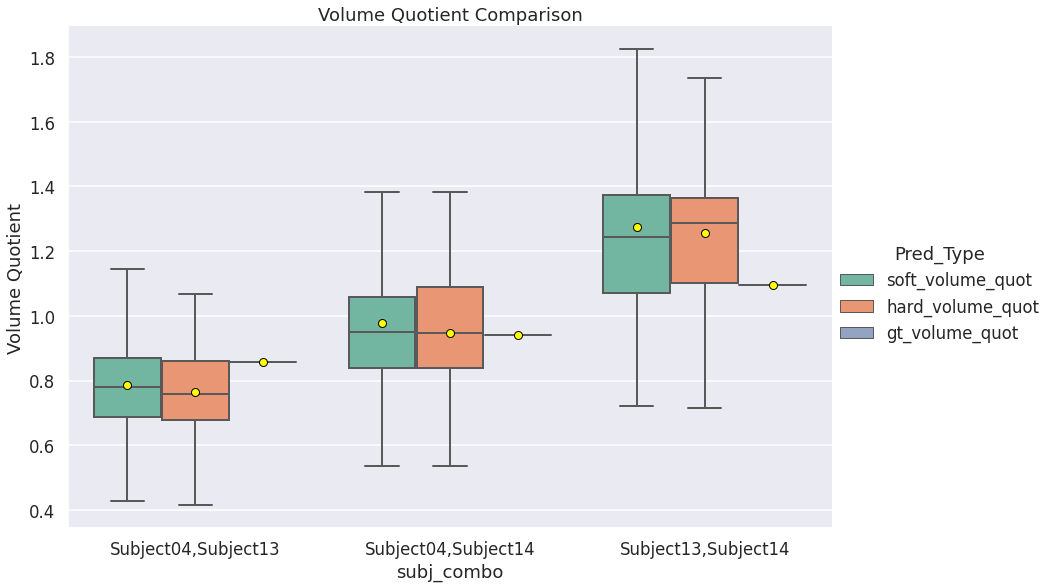

In [11]:
# Create the boxplot
g = sns.catplot(
    x='subj_combo',
    y='Volume Quotient',
    kind='box',
    data=pw_quot_df,
    hue='Pred_Type',
    palette="Set2",       # Use a color palette
    linewidth=2,          # Set the linewidth of the edge
    aspect=1.5,            # Adjust the aspect ratio
    height=8,
    showfliers=False,     # Do not show outliers
    showmeans=True,       # Show the mean
    meanprops={"marker":"o", "markerfacecolor":"yellow", "markeredgecolor":"black", "markersize":"8"}
)
plt.title('Volume Quotient Comparison')

# Test 3: What does the distribution of difference errors to look like?

In [12]:
# Melt the dataframe
pw_diff_error_df = pd.melt(
    pairwise_df, 
    id_vars=[
        'subj_id_1', 
        'subj_id_2', 
        'sup_id_1', 
        'sup_id_2', 
        'subj_combo'
    ], 
    value_vars=[
        'soft_diff_error', 
        'hard_diff_error'
    ], 
    var_name='Pred_Type', 
    value_name='Volume Diff Measurement Error'
)

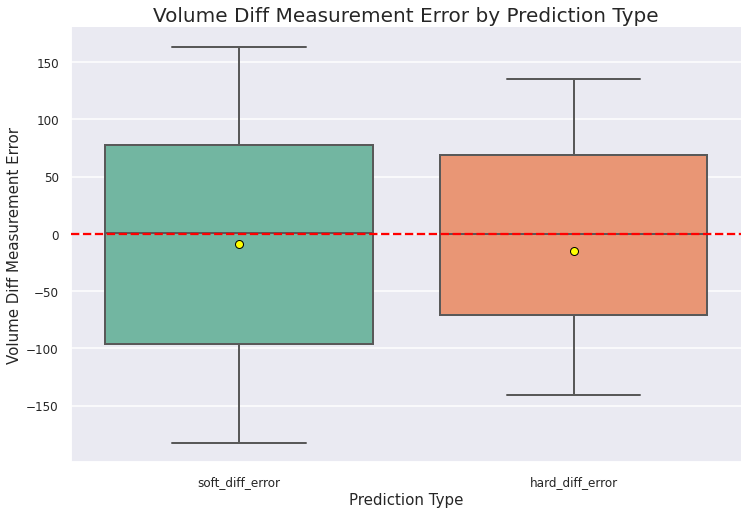

In [13]:
# Create a larger figure
plt.figure(figsize=(12, 8))

# Create the boxplot with modified whiskers and without showing outliers
ax = sns.boxplot(
    x='Pred_Type',
    y='Volume Diff Measurement Error',
    data=pw_diff_error_df,
    palette="Set2",       # Use a color palette
    linewidth=2,          # Set the linewidth of the edge
    showfliers=False,     # Do not show outliers
    whis=0.5,              # Shorten the whiskers to half the IQR
    showmeans=True,       # Show the mean
    meanprops={"marker":"o", "markerfacecolor":"yellow", "markeredgecolor":"black", "markersize":"8"}
)

# Enhance the plot
ax.set_title('Volume Diff Measurement Error by Prediction Type', fontsize=20)
ax.set_xlabel('Prediction Type', fontsize=15)
ax.set_ylabel('Volume Diff Measurement Error', fontsize=15)
ax.tick_params(labelsize=12)

# Remove the top and right spines for a cleaner look
sns.despine()

# Add a dashed red line at y = 0
plt.axhline(y=0, color='r', linestyle='--', zorder=3)

# Show the plot
plt.show()

# Test 3.5: Per-subject, how do the real compare with respect to quotient?

Text(0.5, 1.0, 'Volume Diff Measurement Error by Subject Pair')

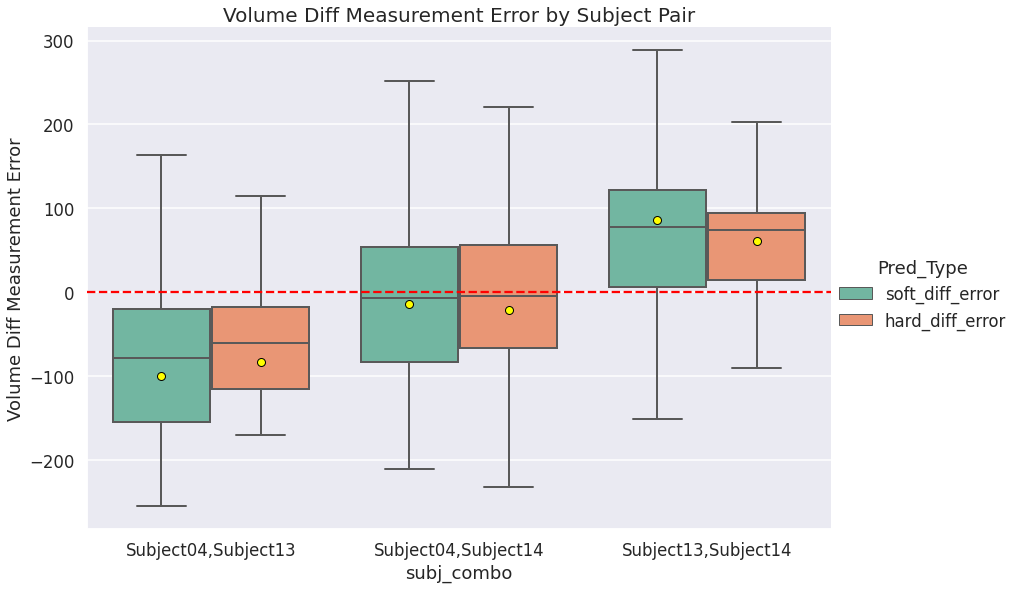

In [14]:
# Create the boxplot
g = sns.catplot(
    x='subj_combo',
    y='Volume Diff Measurement Error',
    kind='box',
    data=pw_diff_error_df,
    hue='Pred_Type',
    palette="Set2",       # Use a color palette
    linewidth=2,          # Set the linewidth of the edge
    aspect=1.5,            # Adjust the aspect ratio
    height=8,
    showfliers=False,     # Do not show outliers
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"yellow", "markeredgecolor":"black", "markersize":"8"}
)

# Add a dashed red line at y = 0
plt.axhline(y=0, color='r', linestyle='--', zorder=3)
plt.title('Volume Diff Measurement Error by Subject Pair', fontsize=20)

# Test 4: What does the distribution of errors of the quotient to look like?

In [15]:
# Melt the dataframe
pw_quot_error_df = pd.melt(
    pairwise_df, 
    id_vars=[
        'subj_id_1', 
        'subj_id_2', 
        'sup_id_1', 
        'sup_id_2', 
        'subj_combo'
    ], 
    value_vars=[
        'soft_quot_error', 
        'hard_quot_error'
    ], 
    var_name='Pred_Type', 
    value_name='Volume Quotient Measurement Error'
)

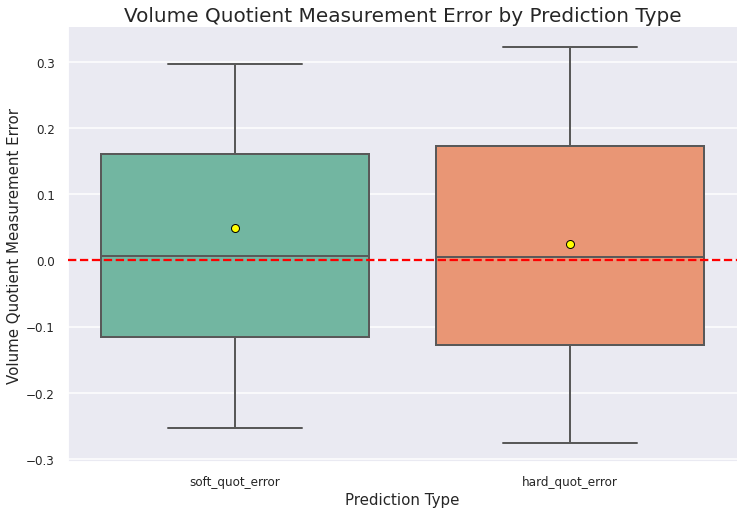

In [16]:
# Create a larger figure
plt.figure(figsize=(12, 8))

# Create the boxplot with modified whiskers and without showing outliers
ax = sns.boxplot(
    x='Pred_Type',
    y='Volume Quotient Measurement Error',
    data=pw_quot_error_df,
    palette="Set2",       # Use a color palette
    linewidth=2,          # Set the linewidth of the edge
    showfliers=False,     # Do not show outliers
    whis=0.5,              # Shorten the whiskers to half the IQR
    showmeans=True,       # Show the mean
    meanprops={"marker":"o", "markerfacecolor":"yellow", "markeredgecolor":"black", "markersize":"8"}
)

# Enhance the plot
ax.set_title('Volume Quotient Measurement Error by Prediction Type', fontsize=20)
ax.set_xlabel('Prediction Type', fontsize=15)
ax.set_ylabel('Volume Quotient Measurement Error', fontsize=15)
ax.tick_params(labelsize=12)

# Remove the top and right spines for a cleaner look
sns.despine()

# Add a dashed red line at y = 0
plt.axhline(y=0, color='r', linestyle='--', zorder=3)

# Show the plot
plt.show()

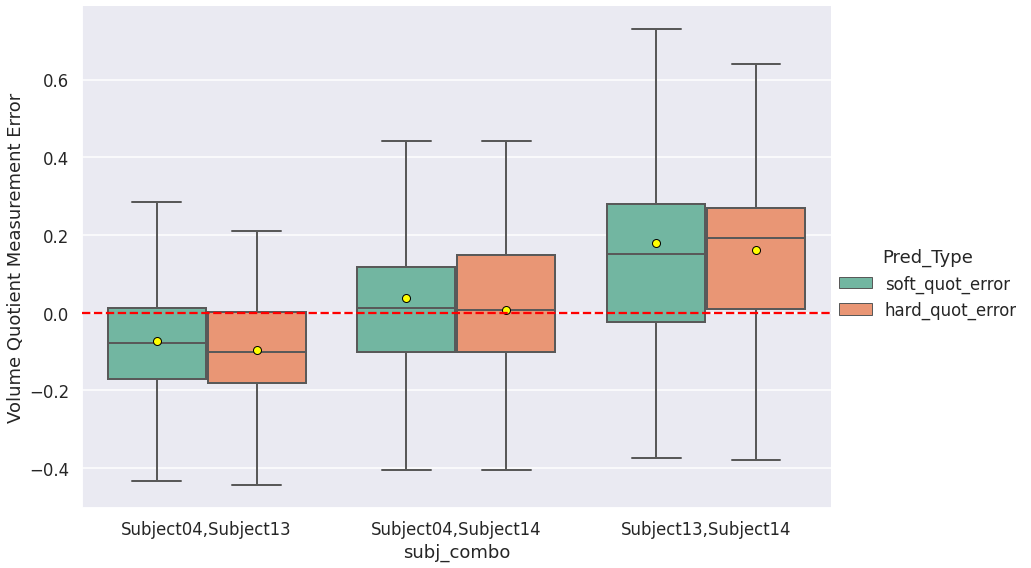

In [17]:
# Create the boxplot
g = sns.catplot(
    x='subj_combo',
    y='Volume Quotient Measurement Error',
    kind='box',
    data=pw_quot_error_df,
    hue='Pred_Type',
    palette="Set2",       # Use a color palette
    linewidth=2,          # Set the linewidth of the edge
    aspect=1.5,            # Adjust the aspect ratio
    height=8,
    showfliers=False,     # Do not show outliers
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"yellow", "markeredgecolor":"black", "markersize":"8"}
)

# Add a dashed red line at y = 0
plt.axhline(y=0, color='r', linestyle='--', zorder=3)